# +4K bad?

Did I make a mistake when setting up the +4K simulations?

In [37]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png
    )

from classes import SatComp_Metric, CT_SLF_Metric
from collections import deque
%matplotlib inline

### Check running location and adjust working directory appropriately.

In [38]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = 'figures/'
case_dir = 'satcomp/'   # inconsistent label compared to jupy_test
conv_dir ='convectivephase/'

# Check that each important directory can be accessed:    
access_paths = os.path.exists(output_dir) and os.path.exists(case_dir) and os.path.exists(conv_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


## I am demonstrating that I did the +4K simulations correctly.

I look at the difference in surface temperature over land between the unperturbed and +4K simulations at the beginning, middle, and end of a 4-year simulation.

Load March data for 2009,2011,2013.

In [39]:
noresm2_og = xr.open_dataset('satcomp/20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1/atm/hist/20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1.cam.h0.2009-03.nc')
noresm2_4k = xr.open_dataset('satcomp_+4K/20200817_4Ksst_cam6satcomp_wbf_1_inp_1/atm/hist/20200817_4Ksst_cam6satcomp_wbf_1_inp_1.cam.h0.2009-03.nc')

In [40]:
noresm2_ogm = xr.open_dataset('satcomp/20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1/atm/hist/20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1.cam.h0.2011-03.nc')
noresm2_4km = xr.open_dataset('satcomp_+4K/20200817_4Ksst_cam6satcomp_wbf_1_inp_1/atm/hist/20200817_4Ksst_cam6satcomp_wbf_1_inp_1.cam.h0.2011-03.nc')

In [41]:
noresm2_ogf = xr.open_dataset('satcomp/20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1/atm/hist/20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1.cam.h0.2013-03.nc')
noresm2_4kf = xr.open_dataset('satcomp_+4K/20200817_4Ksst_cam6satcomp_wbf_1_inp_1/atm/hist/20200817_4Ksst_cam6satcomp_wbf_1_inp_1.cam.h0.2013-03.nc')

Calculate the difference in surface temperature over land (with bad weighting)

Here, we can see that the land surfaces are only 2.7K warmer in the +4K simulation. In the first month, the land hasn't had time to catch up to the much warmer oceans.

In [46]:
(noresm2_4k['TS'].mean('time') - noresm2_og['TS'].mean('time')).where(noresm2_og['LANDFRAC'] > 0.95).mean(dim=['lat','lon'])

<xarray.DataArray 'TS' (time: 1)>
array([2.7275178], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2009-04-01

In the middle and final year, the land surfaces are on average 6K warmer in the +4K simulation. This makes sense when we think about the positive feedbacks that are active.

In [47]:
(noresm2_4km['TS'].mean('time') - noresm2_ogm['TS'].mean('time')).where(noresm2_ogm['LANDFRAC'] > 0.95).mean(dim=['lat','lon'])

<xarray.DataArray 'TS' (time: 1)>
array([6.0354567], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2011-04-01

In [48]:
(noresm2_4kf['TS'].mean('time') - noresm2_ogf['TS'].mean('time')).where(noresm2_ogf['LANDFRAC'] > 0.95).mean(dim=['lat','lon'])

<xarray.DataArray 'TS' (time: 1)>
array([6.016805], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2013-04-01

In [13]:
cd ../

/mnt/mcc-ns9600k/jonahks


In [14]:
ls

AMWG_diag/                 Diagnostics_Output/  NoresmDiagnostics/
caliop_olimpia/            feedbacks_soden/     NorESM_validation/
caliop_olimpia_new/        figures/             nudging_dev/
caliop_slfs/               git_repos/           olimpia_cosp/
CAM6_satcomp_wbf_1_inp_1/  GOCCP_data/          resolution_stuff/
CERES_EBAF/                inp_obs/             satcomp/
conspiracy_stuff/          inp_validation/      satcomp_+4K/
convectivephase/           mnth15runs/          slf_validation/


In [16]:
sst_og = xr.open_dataset('satcomp_+4K/sst_HadOIBl_bc_1.9x2.5_2000climo_c180511.nc')
sst_4k = xr.open_dataset('satcomp_+4K/sst_HadOIBl+4K_bc_1.9x2.5_2000climo_c180511.nc')

__Why are they the same?__

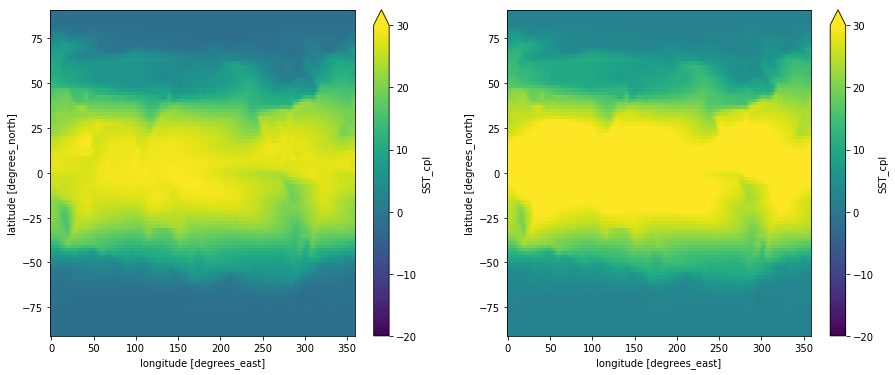

In [22]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

sst_og['SST_cpl'].mean('time').plot(ax=ax1,vmin=-20,vmax=30,cmap='viridis')
sst_4k['SST_cpl'].mean('time').plot(ax=ax2,vmin=-20,vmax=30,cmap='viridis')

__Ok, I'm just going to compare outputs then.__

In [23]:
ls

AMWG_diag/                 Diagnostics_Output/  NoresmDiagnostics/
caliop_olimpia/            feedbacks_soden/     NorESM_validation/
caliop_olimpia_new/        figures/             nudging_dev/
caliop_slfs/               git_repos/           olimpia_cosp/
CAM6_satcomp_wbf_1_inp_1/  GOCCP_data/          resolution_stuff/
CERES_EBAF/                inp_obs/             satcomp/
conspiracy_stuff/          inp_validation/      satcomp_+4K/
convectivephase/           mnth15runs/          slf_validation/


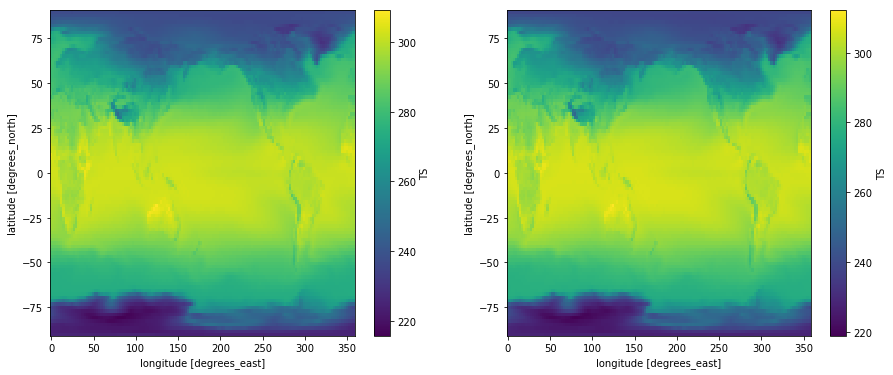

In [26]:
fig2 = plt.figure(figsize=(15,6))
ax1b = fig2.add_subplot(1,2,1)
ax2b = fig2.add_subplot(1,2,2)

noresm2_og['TS'].mean('time').plot(ax=ax1b)#,vmin=-20,vmax=30,cmap='viridis')
noresm2_4k['TS'].mean('time').plot(ax=ax2b)#,vmin=-20,vmax=30,cmap='viridis')

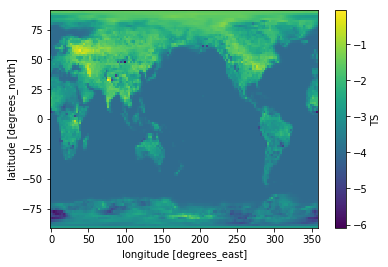

In [27]:
(noresm2_og['TS'].mean('time') - noresm2_4k['TS'].mean('time')).plot()#,vmin=-20,vmax=30,cmap='viridis')

Is this good or bad? The SSTs are offset by 4K, which is correct, and most of the surface temperatures are less so do they respond just that quickly?

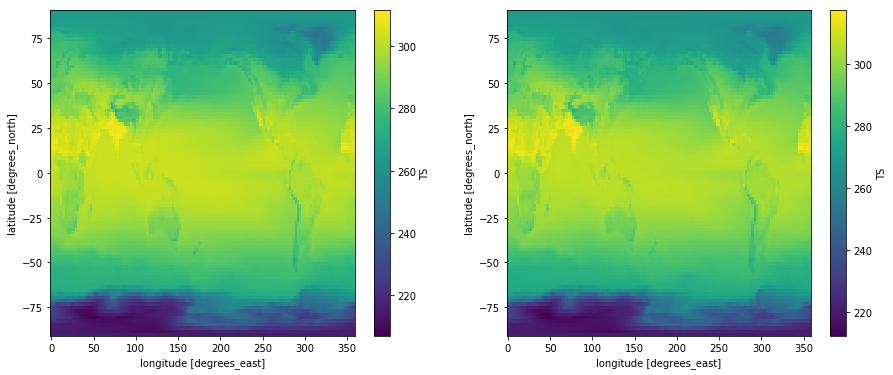

In [31]:
fig3 = plt.figure(figsize=(15,6))
ax1c = fig3.add_subplot(1,2,1)
ax2c = fig3.add_subplot(1,2,2)

noresm2_ogf['TS'].mean('time').plot(ax=ax1c)#,vmin=-20,vmax=30,cmap='viridis')
noresm2_4kf['TS'].mean('time').plot(ax=ax2c)#,vmin=-20,vmax=30,cmap='viridis')

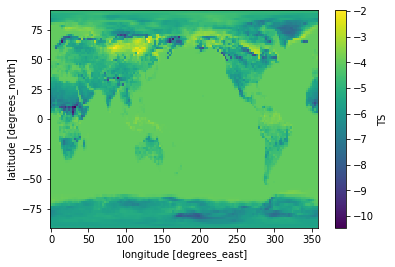

In [32]:
(noresm2_ogf['TS'].mean('time') - noresm2_4kf['TS'].mean('time')).plot()#,vmin=-20,vmax=30,cmap='viridis')

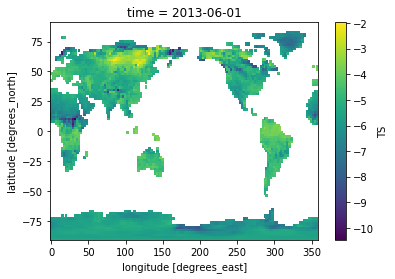

In [33]:
(noresm2_ogf['TS'].mean('time') - noresm2_4kf['TS'].mean('time')).where(noresm2_ogf['LANDFRAC'] > 0.95).plot()

In [46]:
(noresm2_4k['TS'].mean('time') - noresm2_og['TS'].mean('time')).where(noresm2_og['LANDFRAC'] > 0.95).mean(dim=['lat','lon'])

<xarray.DataArray 'TS' (time: 1)>
array([2.7275178], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2009-04-01

In [47]:
(noresm2_4km['TS'].mean('time') - noresm2_ogm['TS'].mean('time')).where(noresm2_ogm['LANDFRAC'] > 0.95).mean(dim=['lat','lon'])

<xarray.DataArray 'TS' (time: 1)>
array([6.0354567], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2011-04-01

In [48]:
(noresm2_4kf['TS'].mean('time') - noresm2_ogf['TS'].mean('time')).where(noresm2_ogf['LANDFRAC'] > 0.95).mean(dim=['lat','lon'])

<xarray.DataArray 'TS' (time: 1)>
array([6.016805], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2013-04-01

In [5]:
ls /cluster/shared/noresm/inputdata/atm/cam/sst/

ls: cannot access '/cluster/shared/noresm/inputdata/atm/cam/sst/': No such file or directory


In [ ]:
noresm2_ogf['LANDFRAC']